In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import keras

In [2]:
# The directory path for Mini Project Folder
directory_path = r'D:\studies\Mini Project'

In [3]:
images = []
image_labels = []
image_height = 35
image_width = 35

In [4]:
train_df = pd.read_csv('D:\studies\Mini Project\Train.csv')

In [5]:
# function to open and return the resized image
def get_image(img_path, height, width):
    image = Image.open(img_path)
    resized_image = image.resize((height, width))
    return resized_image


In [6]:
# storing the image and its label
for index in range(train_df.shape[0]):
    try:
        img_path = train_df.loc[index, 'Path']
        img_label = train_df.loc[index, 'ClassId']
        
        image_path = directory_path+ '\\' + img_path
        
        image = get_image(image_path, image_height, image_width)
        image_array = np.array(image)
        images.append(image_array)
        image_labels.append(img_label)

    except:
        pass

In [7]:
meta_df = pd.read_csv(directory_path + '//' + '/Meta.csv')

In [8]:
# number of class labels in the given dataset
number_of_unique_signs = meta_df['ClassId'].shape[0]

In [9]:
# Randomly shuffling the indexes for splitting
indexes = np.arange(len(images))
np.random.shuffle(indexes)

In [10]:
# Converting python lists into numpy arrays
images = np.array(images)
image_labels = np.array(image_labels)

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images, image_labels, test_size=0.2)

In [34]:
# Normalising the data
X_train = X_train/255.0
X_val = X_val/255.0

In [32]:
# One hot Encoding the class labels
y_train = pd.get_dummies(y_train)
y_val = pd.get_dummies(y_val)

In [14]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, InputLayer
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot

In [15]:
input_shape = X_train.shape[1:]
input_shape

(35, 35, 3)

In [17]:
from tensorflow.keras.models import load_model
encoder = load_model("encoder.h5")

In [43]:
def build_autoencoder(input_shape, n_bottleneck):
    
    n_inputs = np.prod(input_shape)
    
    encoder = Sequential(name = "Encoder")
    # Encoder 1
    encoder.add(InputLayer(input_shape))
    encoder.add(Flatten())
    encoder.add(Dense(n_inputs*1.5))
    encoder.add(BatchNormalization())
    encoder.add(LeakyReLU())
    # Encoder 2
    encoder.add(Dense(n_inputs//2))
    encoder.add(BatchNormalization())
    encoder.add(LeakyReLU())
    
    encoder.add(Dense(n_bottleneck))
    
    decoder = Sequential(name = "Decoder")
    # Decoder 1
    decoder.add(InputLayer((n_bottleneck,)))
    decoder.add(Dense(n_inputs//2))
    decoder.add(BatchNormalization())
    decoder.add(LeakyReLU())
    # Decoder 2
    decoder.add(Dense(n_inputs*1.5))
    decoder.add(BatchNormalization())
    decoder.add(LeakyReLU())
    
    decoder.add(Dense(n_inputs))
    decoder.add(Reshape(input_shape))
    
    return encoder, decoder

In [ ]:
encoder, decoder = build_autoencoder(input_shape, 100)
inp = Input(input_shape)
bottleneck = encoder(inp)
reconstructed = decoder(bottleneck)

autoencoder = Model(inp, reconstructed)
autoencoder.compile(optimizer = "Adam", loss = "mse")

In [45]:
print(autoencoder.summary())

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 35, 35, 3)]       0         
                                                                 
 Encoder (Sequential)        (None, 100)               30602689  
                                                                 
 Decoder (Sequential)        (None, 35, 35, 3)         30606264  
                                                                 
Total params: 61,208,953
Trainable params: 61,179,557
Non-trainable params: 29,396
_________________________________________________________________
None


In [47]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=10,
                validation_data=[X_val, X_val])

Epoch 1/10
981/981 [==============================] - 387s 389ms/step - loss: 0.0448 - val_loss: 0.0302
Epoch 2/10
981/981 [==============================] - 292s 298ms/step - loss: 0.0244 - val_loss: 0.0355
Epoch 3/10
981/981 [==============================] - 353s 360ms/step - loss: 0.0208 - val_loss: 0.0267
Epoch 4/10
981/981 [==============================] - 324s 330ms/step - loss: 0.0181 - val_loss: 0.0139
Epoch 5/10
981/981 [==============================] - 358s 365ms/step - loss: 0.0156 - val_loss: 0.0148
Epoch 6/10
981/981 [==============================] - 302s 307ms/step - loss: 0.0133 - val_loss: 0.0111
Epoch 7/10
981/981 [==============================] - 306s 312ms/step - loss: 0.0120 - val_loss: 0.0097
Epoch 8/10
981/981 [==============================] - 289s 295ms/step - loss: 0.0115 - val_loss: 0.0089
Epoch 9/10
981/981 [==============================] - 282s 287ms/step - loss: 0.0109 - val_loss: 0.0097
Epoch 10/10
981/981 [==============================] - 287s 292m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

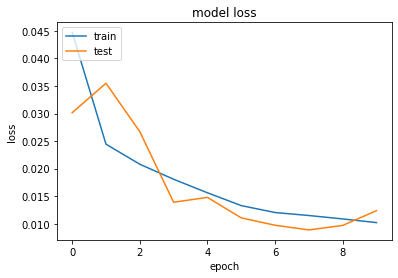

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [50]:
encoder.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 3675)              0         
                                                                 
 dense_36 (Dense)            (None, 5512)              20262112  
                                                                 
 batch_normalization_24 (Bat  (None, 5512)             22048     
 chNormalization)                                                
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 5512)              0         
                                                                 
 dense_37 (Dense)            (None, 1837)              10127381  
                                                                 
 batch_normalization_25 (Bat  (None, 1837)             7348      
 chNormalization)                                          

In [18]:
list(encoder.get_weights()[7])

[2.2363263e-08,
 5.009305e-08,
 -6.7770756e-08,
 -8.6836046e-08,
 5.5698596e-08,
 8.471438e-08,
 -3.7496196e-08,
 -1.135695e-08,
 2.0455114e-07,
 -1.7168407e-08,
 1.1448659e-08,
 2.8755577e-08,
 1.2184444e-07,
 -1.1336581e-09,
 -6.652877e-08,
 -2.3074449e-08,
 -1.1554632e-07,
 -4.2592223e-08,
 -2.767363e-08,
 -8.490766e-08,
 2.2577615e-07,
 -8.636346e-08,
 -5.3274146e-08,
 1.5109904e-08,
 4.996069e-08,
 2.2193503e-07,
 1.4200289e-07,
 6.6380546e-09,
 8.689814e-09,
 1.3861674e-07,
 -8.7825605e-08,
 7.91433e-08,
 -2.2268472e-08,
 -1.1898831e-07,
 -7.231586e-08,
 -2.1453662e-08,
 3.730073e-08,
 -1.1480851e-08,
 1.04479845e-07,
 4.726331e-10,
 1.1896723e-07,
 -2.1432133e-07,
 -2.9840326e-08,
 1.1251233e-07,
 -7.354176e-08,
 -1.6623383e-07,
 -5.089429e-08,
 -1.1166465e-07,
 1.7404757e-07,
 1.0255875e-07,
 1.1242964e-07,
 -7.525877e-08,
 7.05355e-08,
 -8.100478e-08,
 -5.0832355e-08,
 1.2373343e-07,
 -1.1608891e-07,
 1.2066246e-07,
 -2.3989756e-08,
 -5.0872817e-08,
 -7.661192e-08,
 -9.345235e

In [74]:
list(autoencoder.get_weights()[7])

[2.2363263e-08,
 5.009305e-08,
 -6.7770756e-08,
 -8.6836046e-08,
 5.5698596e-08,
 8.471438e-08,
 -3.7496196e-08,
 -1.135695e-08,
 2.0455114e-07,
 -1.7168407e-08,
 1.1448659e-08,
 2.8755577e-08,
 1.2184444e-07,
 -1.1336581e-09,
 -6.652877e-08,
 -2.3074449e-08,
 -1.1554632e-07,
 -4.2592223e-08,
 -2.767363e-08,
 -8.490766e-08,
 2.2577615e-07,
 -8.636346e-08,
 -5.3274146e-08,
 1.5109904e-08,
 4.996069e-08,
 2.2193503e-07,
 1.4200289e-07,
 6.6380546e-09,
 8.689814e-09,
 1.3861674e-07,
 -8.7825605e-08,
 7.91433e-08,
 -2.2268472e-08,
 -1.1898831e-07,
 -7.231586e-08,
 -2.1453662e-08,
 3.730073e-08,
 -1.1480851e-08,
 1.04479845e-07,
 4.726331e-10,
 1.1896723e-07,
 -2.1432133e-07,
 -2.9840326e-08,
 1.1251233e-07,
 -7.354176e-08,
 -1.6623383e-07,
 -5.089429e-08,
 -1.1166465e-07,
 1.7404757e-07,
 1.0255875e-07,
 1.1242964e-07,
 -7.525877e-08,
 7.05355e-08,
 -8.100478e-08,
 -5.0832355e-08,
 1.2373343e-07,
 -1.1608891e-07,
 1.2066246e-07,
 -2.3989756e-08,
 -5.0872817e-08,
 -7.661192e-08,
 -9.345235e

In [112]:
X_train_encoded = encoder.predict(X_train)
X_train_encoded

array([[-18.349642  ,   1.1375585 ,  -7.609461  , ..., -14.676793  ,
         -3.7118473 ,  10.031175  ],
       [ -3.124001  ,  -1.1626068 ,  -8.645063  , ...,  -0.26585713,
          1.401668  ,   5.844506  ],
       [ -8.470779  ,  -3.2149491 ,  -4.479137  , ...,   1.1311316 ,
          2.5065393 ,   2.2496874 ],
       ...,
       [ -1.56859   ,  -2.4560387 ,  -8.207541  , ...,  -2.6462803 ,
          1.8568969 ,   5.7659903 ],
       [ 13.698409  ,  13.584096  , -28.596601  , ...,   8.204388  ,
          4.522826  ,  18.927916  ],
       [  5.781323  ,  16.292423  ,  -9.357537  , ...,   4.9815416 ,
         -1.9199255 ,  -0.51209533]], dtype=float32)

In [35]:
X_train_encoded = encoder.predict(X_train)
X_train_encoded

array([[  4.2784343 ,  -0.2971928 ,   2.1885977 , ...,  -4.299693  ,
          5.076619  ,  -1.7757825 ],
       [ -6.355024  ,  -6.929149  ,  -4.8738165 , ...,  27.6764    ,
         -7.9172277 ,  18.658943  ],
       [ -2.8057866 ,   0.72212553,  -3.9128268 , ...,  -1.040718  ,
         10.994931  ,   6.6376066 ],
       ...,
       [-10.364324  ,  -4.9703856 ,  -4.680646  , ...,   0.11207321,
         -0.815837  ,  -1.4906188 ],
       [ -8.5631075 ,   2.8422518 , -11.217572  , ...,  10.266091  ,
          3.118018  ,   6.3896446 ],
       [ -3.6078963 ,  -9.607613  ,   4.661016  , ...,  -4.209953  ,
        -14.229023  ,  -5.0364323 ]], dtype=float32)

In [36]:
# Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

X_train_encoded = sc.fit_transform(X_train_encoded)

In [28]:
X_train_encoded

array([[0.6297975 , 0.58386844, 0.692638  , ..., 0.44346693, 0.7481695 ,
        0.5199693 ],
       [0.52432466, 0.4916335 , 0.5084294 , ..., 0.29716712, 0.6701666 ,
        0.47509283],
       [0.49266922, 0.53679085, 0.5325605 , ..., 0.4404488 , 0.72674394,
        0.5623153 ],
       ...,
       [0.577449  , 0.6042977 , 0.5503167 , ..., 0.35819486, 0.5657734 ,
        0.5018181 ],
       [0.5289495 , 0.48447144, 0.6551602 , ..., 0.34330106, 0.65447456,
        0.59853315],
       [0.67450374, 0.6116045 , 0.6210346 , ..., 0.52386415, 0.7095867 ,
        0.40955928]], dtype=float32)

In [44]:
X_test_encoded = encoder.predict(X_val)
X_test_encoded = sc.transform(X_test_encoded)

In [42]:
from sklearn.ensemble import RandomForestClassifier
# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(criterion = 'entropy', random_state = 42)

In [43]:
classifier.fit(X_train_encoded, y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

In [45]:
y_pred = classifier.predict(X_test_encoded)

In [50]:
from sklearn.metrics import accuracy_score

In [49]:
accuracy_score(y_pred, y_val)

0.8992603927569498

In [52]:
# Testing Phase
data = []
test_df = pd.read_csv(directory_path + "/Test.csv")
for index in range(test_df.shape[0]):
    img_path = test_df.loc[index, 'Path']
    current_path = directory_path + '//' + img_path
    image = get_image(current_path, image_height, image_width)
    image_array = np.array(image)
    data.append(image_array)

In [53]:
X_test = np.array(data)
X_test = X_test/255.0

In [54]:
encoded_X_test = encoder.predict(X_test)

In [55]:
encoded_X_test = sc.transform(encoded_X_test)

In [56]:
y_test = test_df.loc[:,'ClassId']

In [57]:
y_pred = classifier.predict(encoded_X_test)

In [58]:
accuracy_score(y_test, y_pred)

0.511243072050673

In [51]:
import joblib
joblib.dump(classifier, "rf_classifier.pkl")

['rf_classifier.pkl']